<a href="https://colab.research.google.com/github/kgj1234/StockPredictionNotebook/blob/main/Stock_Price_Forecasting_%E2%80%94_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jacksoncrow_stock_market_dataset_path = kagglehub.dataset_download('jacksoncrow/stock-market-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'stock-market-dataset' dataset.
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install numpy==1.26.4 #2.0.2 incompatible with pmdarima
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
;
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/stock-market-dataset/stocks/COKE.csv
/kaggle/input/stock-market-dataset/stocks/FDS.csv
/kaggle/input/stock-market-dataset/stocks/KAI.csv
/kaggle/input/stock-market-dataset/stocks/PPBI.csv
/kaggle/input/stock-market-dataset/stocks/CARS.csv
/kaggle/input/stock-market-dataset/stocks/PD.csv
/kaggle/input/stock-market-dataset/stocks/EAE.csv
/kaggle/input/stock-market-dataset/stocks/RCM.csv
/kaggle/input/stock-market-dataset/stocks/AAON.csv
/kaggle/input/stock-market-dataset/stocks/HKIB.csv
/kaggle/input/stock-market-dataset/stocks/CJJD.csv
/kaggle/input/stock-market-dataset/stocks/BIO.csv
/kaggle/input/stock-market-dataset/stocks/PTN.csv
/kaggle/input/stock-market-dataset/stocks/BBAR.csv
/kaggle/input/stock-market-dataset/stocks/OFS.csv
/kaggle/input/stock-market-dataset/stocks/CYCCP.csv
/kaggle/input/stock-market-dataset/stocks/YRCW.csv
/kaggle/input/stock-market-dataset/stocks/CUB.csv
/kaggle/input/stock-market-dataset/stock

''

# Stock Price Forecasting - Time Series
**Author:** Jane Zhang  
**Objective:** Demonstrate time-series modelling skills with exploratory data analysis, feature engineering, classical and advanced models (ARIMA, XGBoost, Prophet, LSTM, Transformer-style), walk-forward evaluation, metrics and ensembling.


# Table of Contents
1. [Imports & Setup](#setup)  
2. [Load data (CSV or yfinance)](#load)  
3. [Exploratory Data Analysis (EDA)](#eda)  
4. [Feature Engineering & Train/Test split](#fe)
5. [Evaluation helpers](#ev)
6. [Baselines: Naive, Persistence, Moving Average](#baselines)  
7. [Classical model: ARIMA / auto_arima](#arima)  
8. [Prophet (or Prophet-like) model](#prophet)  
9. [Tree-based model: XGBoost with lag features](#xgboost)  
10. [Deep learning: LSTM model](#lstm)  
11. [Model ensembling](#ensemble)  
12. [Final predictions](#prediction)  
13. [Conclusions & Next steps](#conclusion)


## 1.Imports & Setup

In [3]:
# Core imports and reproducibility
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)


## 2.Load the dataset
The cell below tries to load `stock_data.csv` from the notebook's input directory (you can upload your CSV). If not found, it downloads data with `yfinance` for a specified ticker and date range.


In [4]:
# Config: change ticker / start / end if desired
TICKER = "AAPL"   # default, change to any symbol
START = "2015-01-01"
END = datetime.today().strftime("%Y-%m-%d")
INPUT_CSV = "/kaggle/input/stock_data.csv"  # optional user-uploaded CSV

def load_data(ticker=TICKER, start=START, end=END, csv_path=INPUT_CSV):
    if os.path.exists(csv_path):
        print("Loading CSV:", csv_path)
        df = pd.read_csv(csv_path, parse_dates=True)
        # Try to standardize common columns
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date').reset_index(drop=True)
            df.set_index('Date', inplace=True)
        return df
    else:
        print(f"No CSV found at {csv_path}. Downloading {ticker} via yfinance.")
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, progress=False)
        df.index = pd.to_datetime(df.index)
        return df

df = load_data()
print(df.shape)
df.head()


No CSV found at /kaggle/input/stock_data.csv. Downloading AAPL via yfinance.


/tmp/ipython-input-1434608297.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


(2721, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261045,24.729268,23.821670,24.718172,212818400
2015-01-05,23.577576,24.110152,23.391175,24.030265,257142000
2015-01-06,23.579788,23.839418,23.218079,23.641922,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829126,24.886823,24.121244,24.238856,237458000


## 3.Quick EDA
To understand the series behaviour: missing values, trends, seasonality, and volatility. We'll focus on `Close` price for forecasting but keep other columns for features.


Date range: 2015-01-02 00:00:00 to 2025-10-27 00:00:00
Missing values count: Ticker
AAPL    0
dtype: int64


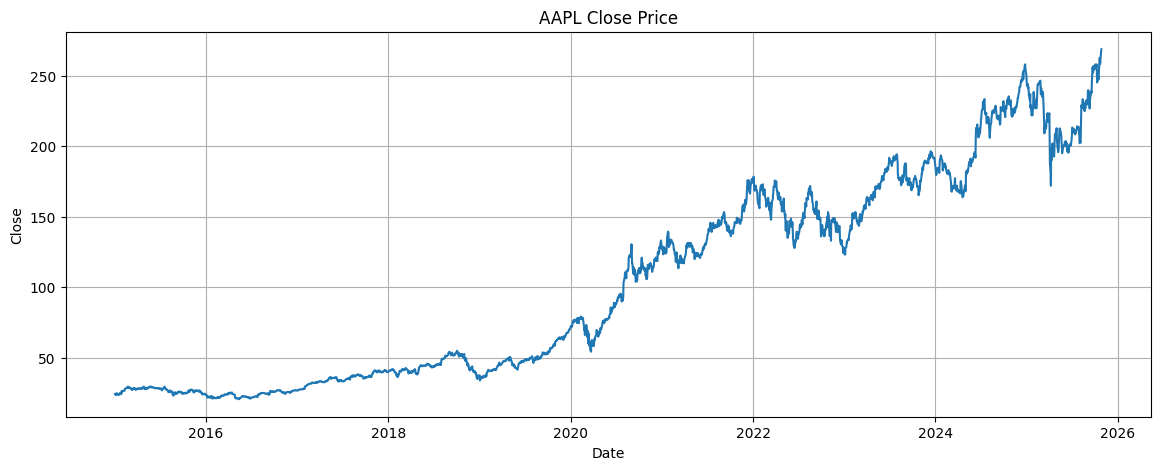

<Figure size 1400x500 with 0 Axes>

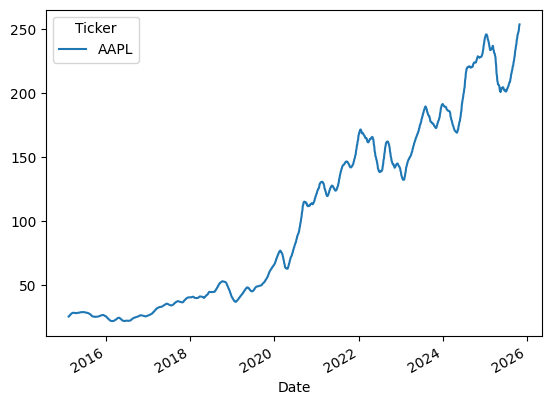

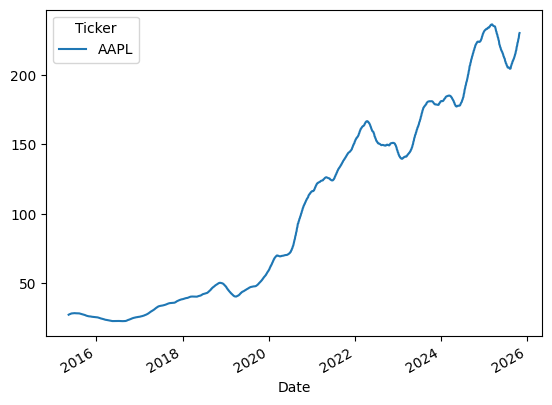

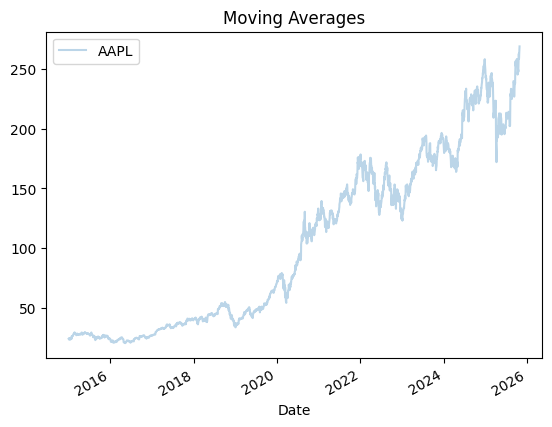

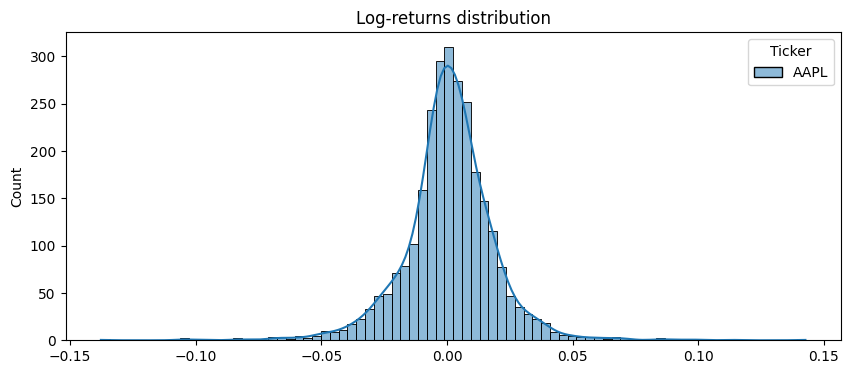

In [5]:
# EDA: summary and plotting
series = df['Close'].copy()
print("Date range:", series.index.min(), "to", series.index.max())
print("Missing values count:", series.isna().sum())

# Simple plot
plt.figure(figsize=(14,5))
plt.plot(series.index, series.values)
plt.title(f"{TICKER} Close Price")
plt.xlabel("Date"); plt.ylabel("Close")
plt.grid(True)
plt.show()

# Rolling statistics
plt.figure(figsize=(14,5))
series.rolling(30).mean().plot(label='30d MA')
series.rolling(90).mean().plot(label='90d MA')
series.plot(alpha=0.3, label='Close')
plt.legend(); plt.title("Moving Averages")
plt.show()

# Log returns distribution
returns = np.log(series).diff().dropna()
plt.figure(figsize=(10,4))
sns.histplot(returns, bins=80, kde=True)
plt.title("Log-returns distribution")
plt.show()


## 4.Feature Engineering & Time-based split
We'll create lag features, rolling statistics, date-based features (day-of-week, month), and a train/validation/test split using chronological (time series aware) partitioning. We also provide functions for reusability.


In [6]:
# Feature engineering helpers
def create_lag_features(df, col='Close', lags=[1,2,3,5,7,14,21], windows=[7,14,21,50]):
    df_feat = df[[col]].copy()
    for l in lags:
        df_feat[f"lag_{l}"] = df_feat[col].shift(l)
    for w in windows:
        df_feat[f"ma_{w}"] = df_feat[col].rolling(w).mean().shift(1) #rolling uses preceding values
        df_feat[f"std_{w}"] = df_feat[col].rolling(w).std().shift(1)
    # returns
    df_feat['ret_1'] = df_feat[col].pct_change().shift(1)
    df_feat['logret_1'] = np.log(df_feat[col]).diff().shift(1)
    # date features
    df_feat['dow'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat = df_feat.dropna()
    return df_feat

df_feat = create_lag_features(df, col='Close')
df_feat.shape


(2671, 20)

In [7]:
df_feat

Price,Close,lag_1,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,ma_7,std_7,ma_14,std_14,ma_21,std_21,ma_50,std_50,ret_1,logret_1,dow,month
Ticker,AAPL,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,
2015-03-17,28.302265,27.836653,27.533669,27.725264,27.738634,28.204250,28.692139,28.311180,27.799419,0.374561,28.238459,0.553379,28.445064,0.602044,26.612771,1.912258,0.011004,0.010944,1,3
2015-03-18,28.620848,28.302265,27.836653,27.533669,27.232916,28.324547,29.055273,28.478264,27.813421,0.393567,28.210611,0.538399,28.444639,0.602146,26.693596,1.896166,0.016727,0.016588,2,3
2015-03-19,28.404747,28.620848,28.302265,27.836653,27.725264,27.738634,28.618626,28.676552,27.855750,0.466818,28.179581,0.496891,28.451429,0.603347,26.794461,1.860837,0.011256,0.011194,3,3
2015-03-20,28.048300,28.404747,28.620848,28.302265,27.533669,27.232916,28.758976,28.616398,27.950909,0.505274,28.164304,0.485512,28.438486,0.601187,26.890960,1.815277,-0.007550,-0.007579,4,3
2015-03-23,28.340145,28.048300,28.404747,28.620848,27.836653,27.725264,28.819122,28.850315,28.067392,0.393871,28.113541,0.454730,28.411434,0.605547,26.973718,1.770390,-0.012549,-0.012628,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-21,262.769989,262.239990,252.289993,247.449997,247.770004,245.270004,255.449997,256.079987,250.288570,5.689727,253.420713,5.143289,253.909522,4.282162,241.728199,11.477834,0.039439,0.038681,1,10
2025-10-22,258.450012,262.769989,262.239990,252.289993,249.339996,247.660004,257.130005,254.429993,252.788568,6.844558,253.943570,5.706663,254.228093,4.681901,242.439999,11.659336,0.002021,0.002019,2,10


In [8]:
# Time-aware train/val/test split (e.g., 70/15/15)
def time_train_test_split(df, train_size=0.7, val_size=0.15):
    n = len(df)
    train_end = int(n*train_size)
    val_end = train_end + int(n*val_size)
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, val, test

train_df, val_df, test_df = time_train_test_split(df_feat, 0.7, 0.15)
print("Train, Val, Test sizes:", len(train_df), len(val_df), len(test_df))


Train, Val, Test sizes: 1869 400 402


In [10]:
test_df

Price,Close,lag_1,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,ma_7,std_7,ma_14,std_14,ma_21,std_21,ma_50,std_50,ret_1,logret_1,dow,month
Ticker,AAPL,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,
2024-03-21,170.148148,177.396103,174.824570,172.481384,171.766510,171.994873,178.379044,181.020096,172.823216,2.496009,171.974311,3.241511,174.938974,5.071560,181.473209,7.089163,0.014709,0.014602,3,3
2024-03-22,171.051666,170.148148,177.396103,174.824570,171.389221,169.909851,173.851547,183.055450,172.559398,2.688340,171.386390,2.690028,174.421262,4.973720,181.204458,7.260093,-0.040857,-0.041716,4,3
2024-03-25,169.631851,171.051666,170.148148,177.396103,172.481384,171.766510,168.907059,181.218643,172.722515,2.530808,171.186398,2.595060,173.849654,4.608152,180.932953,7.382299,0.005310,0.005296,0,3
2024-03-26,168.499969,169.631851,171.051666,170.148148,174.824570,171.389221,167.914169,179.868347,172.417563,2.781403,171.238169,2.552978,173.297902,4.369188,180.644952,7.538179,-0.008301,-0.008335,1,3
2024-03-27,172.074310,168.499969,169.631851,171.051666,177.396103,172.481384,167.795044,181.327835,172.004813,3.149464,171.280012,2.498527,172.756550,4.215989,180.327769,7.710393,-0.006673,-0.006695,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-21,262.769989,262.239990,252.289993,247.449997,247.770004,245.270004,255.449997,256.079987,250.288570,5.689727,253.420713,5.143289,253.909522,4.282162,241.728199,11.477834,0.039439,0.038681,1,10
2025-10-22,258.450012,262.769989,262.239990,252.289993,249.339996,247.660004,257.130005,254.429993,252.788568,6.844558,253.943570,5.706663,254.228093,4.681901,242.439999,11.659336,0.002021,0.002019,2,10


## 5.Evaluation helpers

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    # Avoid division by zero
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_preds(y_true, y_pred, name="model"):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    print(f"Evaluation -> {name}")
    print("RMSE:", rmse(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", mape(y_true, y_pred))


## 6.Baselines: Naive, Persistence, Moving Average
**Always include simple baselines.** We'll compute a naive (y[t] = y[t-1]), a persistence that uses previous day, and a simple moving-average prediction. These are quick sanity checks.


In [10]:
# Baselines on validation set
y_val = val_df['Close']
# 1) Naive (last observed closing price)
naive_pred = val_df['lag_1']  # because lag_1 is previous day's close
evaluate_preds(y_val.values, naive_pred.values, "Naive (lag1)")

# 2) Rolling mean baseline using MA_7 as prediction
ma7_pred = val_df['ma_7']
evaluate_preds(y_val.values, ma7_pred.values, "MA7 baseline")


Evaluation -> Naive (lag1)
RMSE: 2.5223154667884526
MAE: 1.8922017288208008
MAPE: 1.177271533393733
Evaluation -> MA7 baseline
RMSE: 4.250904167185589
MAE: 3.416535350254603
MAPE: 2.1109791295042126


## 7.Classical model: auto_arima
**Auto ARIMA** gives a classical time-series benchmark. We'll fit on the training Close series and forecast the validation horizon. `pmdarima`'s `auto_arima` automates order selection.


In [12]:
# Install pmdarima if missing
!pip install pmdarima

# Fit auto_arima on training Close and forecast length = len(val)
from pmdarima import auto_arima

y_train = train_df['Close']
print("Fitting auto_arima (this may take a few minutes)...")
arima_model = auto_arima(y_train, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_order=10)
print(arima_model.summary())

n_forecast = len(val_df)
arima_pred = arima_model.predict(n_periods=n_forecast)
evaluate_preds(val_df['Close'].values, arima_pred, "AutoARIMA")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.1 MB/s eta 0:00:00
Fitting auto_arima (this may take a few minutes)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1869
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3550.247
Date:                Tue, 28 Oct 2025   AIC                           7106.493
Time:                        15:51:11   BIC                           7123.091
Sample:                             0   HQIC                          7112.609
                               - 1869                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0760      0.035      2.162      0.031       0.007       0.145
ma.L1         -0.0630      0.013     -4.861      0.000      -0.088      -0.038
sigma2         2.6202      0.040     65.250      0.0

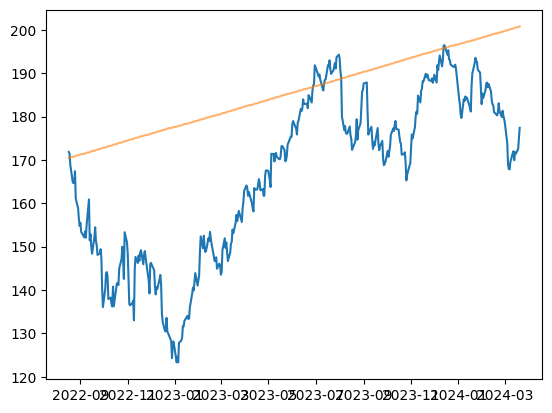

In [17]:
plt.plot(val_df.index, val_df['Close'].values, label='Actual')
plt.plot(val_df.index, arima_pred, alpha=0.6, label='ARIMA')
plt.show()

## 8.Prophet model
**Prophet** (by Meta) is a handy decomposable model (trend + seasonality + holidays). We'll adapt our dataframe to Prophet's `ds`/`y` format and train. Note: Prophet fits quickly for daily series.


In [18]:
# Install Prophet if missing
!pip install prophet --quiet

from prophet import Prophet

print("\n=== Prophet Model ===")

# Ensure single-column, numeric input
prophet_train = pd.DataFrame({
    'ds': pd.to_datetime(train_df.index),
    'y': train_df['Close'].astype(float).values.flatten()
})

prophet_val = pd.DataFrame({
    'ds': pd.to_datetime(val_df.index),
    'y': val_df['Close'].astype(float).values.flatten()
})

# Initialize and fit Prophet
print("Fitting Prophet model (this may take a minute)...")
model_prophet = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)
model_prophet.fit(prophet_train)

# Create a future DataFrame for validation period
future = prophet_val[['ds']]

# Forecast
forecast = model_prophet.predict(future)

# Predictions and evaluation
prophet_pred = forecast['yhat'].values
evaluate_preds(prophet_val['y'].values, prophet_pred, "Prophet")


=== Prophet Model ===
Fitting Prophet model (this may take a minute)...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4g93hvhc/k5xjuxiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4g93hvhc/hge2h6x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77519', 'data', 'file=/tmp/tmp4g93hvhc/k5xjuxiq.json', 'init=/tmp/tmp4g93hvhc/hge2h6x4.json', 'output', 'file=/tmp/tmp4g93hvhc/prophet_modelrjqdz5gh/prophet_model-20251028155640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Evaluation -> Prophet
RMSE: 24.247613451560262
MAE: 21.009410325881234
MAPE: 13.545717201711446


## 9.Tree-based model: XGBoost with lag features
**XGBoost on lag features** often performs strongly for short-term forecasting when framed as supervised learning. We'll train on the engineered features (lags, moving averages) and predict Close.


In [19]:
import xgboost as xgb

# Remove target and ensure numeric features only
FEATURES = [c for c in train_df.columns if c not in ['Close']]

# Convert all features to numeric (timestamps become ordinal numbers)
X_train = train_df[FEATURES].copy()
X_val = val_df[FEATURES].copy()

for df in [X_train, X_val]:
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.datetime64):
            df[col] = df[col].map(pd.Timestamp.toordinal)  # convert dates to numeric
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # convert objects to numeric

y_train = train_df['Close'].values
y_val = val_df['Close'].values

# Convert to numpy arrays
X_train_np = X_train.values
X_val_np = X_val.values

# Create DMatrix
dtrain = xgb.DMatrix(X_train_np, label=y_train)
dval = xgb.DMatrix(X_val_np, label=y_val)

# XGBoost params
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': RSEED,
    'verbosity': 0,
    'max_depth': 6,
    'eta': 0.05
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

# Train
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=50
)

# Predict and evaluate
xgb_pred = xgb_model.predict(dval)
evaluate_preds(y_val, xgb_pred, "XGBoost (lag features)")

[0]	train-rmse:44.73619	val-rmse:95.84838
[50]	train-rmse:3.57959	val-rmse:14.44469
[100]	train-rmse:0.35382	val-rmse:7.23889
[150]	train-rmse:0.14816	val-rmse:6.56950
[200]	train-rmse:0.11596	val-rmse:6.46403
[250]	train-rmse:0.09622	val-rmse:6.46612
[262]	train-rmse:0.09304	val-rmse:6.46242
Evaluation -> XGBoost (lag features)
RMSE: 6.462417415803846
MAE: 3.6009268951416016
MAPE: 1.932670854490844


## 10.Deep Learning: LSTM
**LSTM** sequence-to-one model: we create sliding windows (e.g., 30 days input -> predict next day). This requires a GPU for faster training but will run on CPU (slower). We'll build a reproducible pipeline using TensorFlow/Keras.


In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1. Prepare features and target
# -------------------------------
FEATURES_NUMERIC = FEATURES.copy()
for col in FEATURES_NUMERIC:
    if np.issubdtype(train_df[col].dtype, np.datetime64):
        train_df[col] = train_df[col].map(pd.Timestamp.toordinal)
        val_df[col] = val_df[col].map(pd.Timestamp.toordinal)

X_train_df = train_df[FEATURES_NUMERIC].copy()
y_train = train_df['Close'].values
X_val_df = val_df[FEATURES_NUMERIC].copy()
y_val = val_df['Close'].values

# -------------------------------
# 2. Scale features (target stays numeric)
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)

X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train_df.index, columns=FEATURES_NUMERIC)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val_df.index, columns=FEATURES_NUMERIC)

# -------------------------------
# 3. Build sequences for LSTM
# -------------------------------
def create_sequences(data_X, data_y, seq_len=30):
    X_seq, y_seq = [], []
    vals_X = data_X.values
    vals_y = data_y
    for i in range(seq_len, len(data_X)):
        X_seq.append(vals_X[i-seq_len:i, :])
        y_seq.append(vals_y[i])
    return np.array(X_seq), np.array(y_seq)

seq_len = 30
X_tr, y_tr = create_sequences(X_train_scaled_df, y_train, seq_len)
X_va, y_va = create_sequences(
    pd.concat([X_train_scaled_df.tail(seq_len), X_val_scaled_df]),
    np.concatenate([y_train[-seq_len:], y_val]),
    seq_len
)

print("LSTM shapes:", X_tr.shape, y_tr.shape, X_va.shape, y_va.shape)

# -------------------------------
# 4. Build and train LSTM model
# -------------------------------
tf.keras.utils.set_random_seed(RSEED)

model_lstm = Sequential([
    LSTM(64, input_shape=(X_tr.shape[1], X_tr.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_lstm.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# -------------------------------
# 5. Evaluate LSTM on validation set
# -------------------------------
lstm_pred = model_lstm.predict(X_va).flatten()
evaluate_preds(y_va, lstm_pred, "LSTM")


LSTM shapes: (1839, 30, 20) (1839, 1) (400, 30, 20) (400, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873 (93.25 KB)

 Trainable params: 23,873 (93.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
58/58 - 4s - 61ms/step - loss: 5957.2671 - mae: 62.5335 - val_loss: 21427.4395 - val_mae: 145.1435
Epoch 2/100
58/58 - 1s - 16ms/step - loss: 3394.5435 - mae: 40.2356 - val_loss: 12672.4102 - val_mae: 110.9569
Epoch 3/100
58/58 - 1s - 16ms/step - loss: 1344.9039 - mae: 21.4081 - val_loss: 5648.9917 - val_mae: 72.7284
Epoch 4/100
58/58 - 1s - 19ms/step - loss: 418.6611 - mae: 11.9857 - val_loss: 2258.6829 - val_mae: 43.5993
Epoch 5/100
58/58 - 2s - 29ms/step - loss: 150.1223 - mae: 7.5405 - val_loss: 1106.3203 - val_mae: 28.5688
Epoch 6/100
58/58 - 1s - 20ms/step - loss: 85.3355 - mae: 6.1685 - val_loss: 712.5692 - val_mae: 22.3999
Epoch 7/100
58/58 - 1s - 16ms/step - loss: 69.1663 - mae: 5.6591 - val_loss: 547.5710 - val_mae: 20.2049
Epoch 8/100
58/58 - 1s - 17ms/step - loss: 53.4406 - mae: 5.0604 - val_loss: 409.6533 - val_mae: 16.4332
Epoch 9/100
58/58 - 1s - 16ms/step - loss: 65.3021 - mae: 5.5009 - val_loss: 325.1887 - val_mae: 14.4172
Epoch 10/100
58/58 - 1s - 16ms/ste

## 11.Model ensembling
**Simple ensemble**: average the best model predictions (e.g., XGBoost + LSTM + Transformer) on the validation/test sets. Ensembles tend to be more stable.


In [22]:
# Ensure we have aligned val predictions from models (xgb_pred, prophet_forecast, pred_lstm_val, pred_trans_val)
# For demonstration, ensemble XGBoost + LSTM + Transformer (align lengths carefully)
# We'll ensemble on the earlier validation set (y_va)
from sklearn.metrics import mean_squared_error

# Take last min-length portion for fairness
min_len = min(len(xgb_pred), len(lstm_pred), len(prophet_pred))
ensemble_preds = (xgb_pred[-min_len:] + lstm_pred[-min_len:]) / 2.0
y_true_ens = y_va[-min_len:]
evaluate_preds(y_true_ens, ensemble_preds, "Ensemble (XGB+LSTM)")


Evaluation -> Ensemble (XGB+LSTM)
RMSE: 6.6573275664428495
MAE: 4.58790620803833
MAPE: 2.5821105765335113


## 12.Visualize predictions

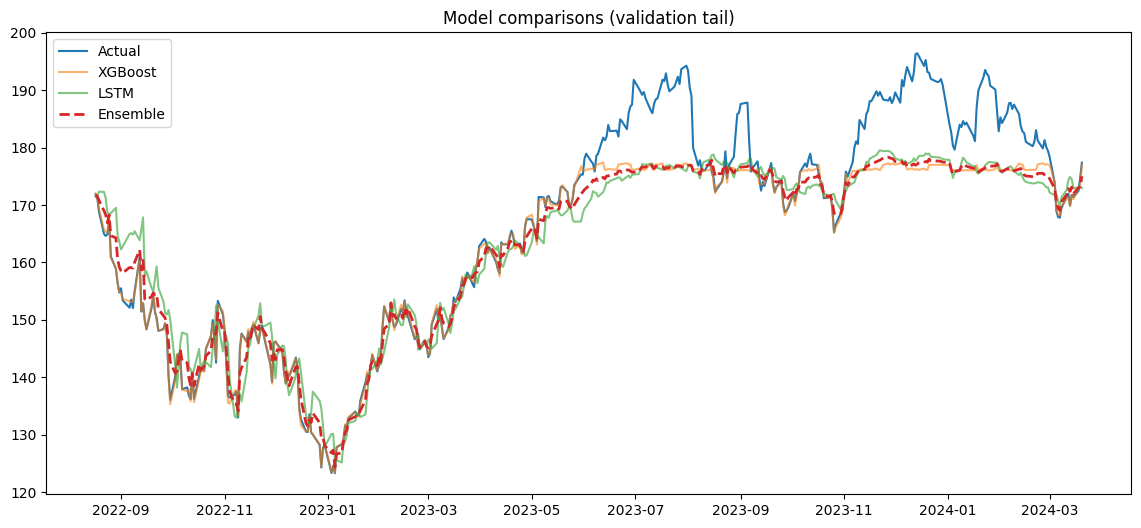

In [23]:
# Plot actual vs predicted on validation tail
plt.figure(figsize=(14,6))
plt.plot(val_df.index[-min_len:], y_true_ens, label='Actual')
plt.plot(val_df.index[-min_len:], xgb_pred[-min_len:], alpha=0.6, label='XGBoost')
plt.plot(val_df.index[-min_len:], lstm_pred[-min_len:], alpha=0.6, label='LSTM')
plt.plot(val_df.index[-min_len:], ensemble_preds, linewidth=2, linestyle='--', label='Ensemble')
plt.legend(); plt.title("Model comparisons (validation tail)")
plt.show()


## 13.Conclusions & Next steps

- **Baselines are essential.** Naive and moving-average baselines set the minimum bar; complex models must outperform them consistently (preferably under walk-forward).
- **Feature engineering matters.** Lag features, rolling stats and calendar features significantly boost tree-based models like XGBoost.
- **Deep learning needs careful setup.** LSTM models can outperform classical models but require more tuning, longer training and GPU acceleration.
- **Ensembling improves stability.** Averaging diverse models usually reduces variance.

**Next steps**
- Add more technical indicators (RSI, MACD), or use `ta` / `pandas_ta`.
- Hyperparameter tuning (Optuna for XGBoost, KerasTuner for NN).
- Multi-step forecasting (predict next 7 days) using seq2seq or direct multi-output setups.
- Add exogenous features: macro data, news sentiment, volume features, options-implied vol.
- Productionize: build inference pipeline and Docker container; test in a paper-trading environment (paper money).
